In [1]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import json
import numpy as np

In [2]:
url = "https://en.wikipedia.org/wiki/List_of_feature_film_series_with_two_entries"

In [3]:
r = requests.get(url)

In [4]:
soup = BeautifulSoup(r.text, 'html.parser')

In [5]:
#mix the soup
m = [item.get_text().split('\n') for item in soup.find_all('ol')]

In [6]:
#Quick function to query the OMDB API
def query_api(title, year):
    
    url = 'http://www.omdbapi.com'
    
    #Handle String years if necessary
    try:
        year = str(int(year))
    except:
        year = 'N/A'
    
    #Populate Params
    params = {'t': title,
           'y': year,
           'apikey': '13deb148'}
    
    #Make the request
    try:
        r = requests.get(url, params=params)
        #print(r)

        json_text = json.loads(r.text)
        #print(json_text)
    except:
        #print(r)
        r = 0
    
    #Populate imdbRating
    try:
        imdb = json_text['imdbRating']
    except:
        imdb = 'N/A'
    
    #Populate Metascore Rating
    try:
        metascore = json_text['Metascore']
    except:
        metascore = 'N/A'
        
    #print(imdb, metascore)
    
    return {'imdb': imdb, 'metascore': metascore}

In [7]:
# Start of second try

In [8]:
l = [item.text.split('\n') for item in soup.find('div', {'class': 'div-col'}).find_all('li')]

In [9]:
def filterList(item):
    return len(item) == 3

clean_list = list(filter(filterList, l))

In [10]:
#TODO: refactor to work with more than 2 movies
titles = [[{'title':item[1], 'series': item[0]}, {'title':item[2], 'series':item[0]}] for item in clean_list]

In [11]:
df = pd.DataFrame([item for sublist in titles for item in sublist])

In [12]:
#Clean up the date column
def return_date(item):
    try:
        return item.split('(')[1].split(')')[0]
    except:
        return np.nan
    
df['date'] = df['title'].apply(lambda x:return_date(x))
df['title_clean'] = df['title'].apply(lambda x: x.split('(')[0])

In [13]:
df

,title,series,date,title_clean
0,00 Schneider – Jagd auf Nihil Baxter (1994),00 Schneider,1994,00 Schneider – Jagd auf Nihil Baxter
1,00 Schneider – Im Wendekreis der Eidechse [de]...,00 Schneider,2013,00 Schneider – Im Wendekreis der Eidechse [de]
2,2 Days in Paris (2007),2 Days in...,2007,2 Days in Paris
3,2 Days in New York (2012),2 Days in...,2012,2 Days in New York
4,8mm (1999),8mm,1999,8mm
...,...,...,...,...
3347,Zulu Dawn (1979) (prequel),Zulu,1979,Zulu Dawn
3348,Zuma (1985),Zuma,1985,Zuma
3349,Anak ni Zuma (1987),Zuma,1987,Anak ni Zuma
3350,Dschungelmädchen für zwei Halunken [de] (1974),Zwei Teufelskerle,1974,Dschungelmädchen für zwei Halunken [de]


In [14]:
def convert_to_int(item):
    try:
        return float(item)
    except:
        return np.nan

df['date'] = df['date'].apply(lambda x: convert_to_int(x))

In [29]:
test_df = df.loc[df['date'] > 1990].head(100).copy()

In [30]:
#test_df

In [31]:
final_df = test_df.merge(test_df.apply(lambda x: pd.Series(query_api(x['title_clean'], x['date'])), axis=1), 
             left_index=True, right_index=True)

In [32]:
series_names = final_df['series'].unique()

In [48]:
final_df['imdb'] = final_df['imdb'].apply(lambda x: convert_to_int(x))
final_df['metascore'] = final_df['metascore'].apply(lambda x: convert_to_int(x))

In [49]:
summary = final_df.groupby('series')['imdb'].last() - final_df.groupby('series')['imdb'].first()

<AxesSubplot:ylabel='Density'>

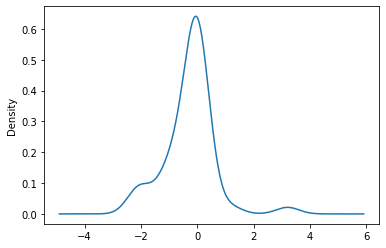

In [50]:
summary.plot.kde()

<AxesSubplot:>

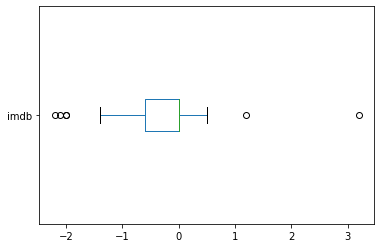

In [51]:
summary.plot.box(vert=False)

<AxesSubplot:ylabel='Frequency'>

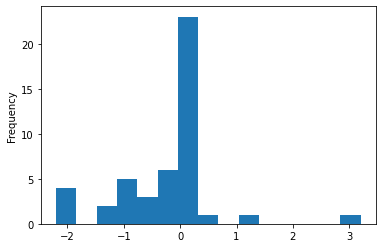

In [55]:
summary.plot.hist(bins=15)

In [56]:
summary.describe()

count    46.000000
mean     -0.276087
std       0.876910
min      -2.200000
25%      -0.600000
50%       0.000000
75%       0.000000
max       3.200000
Name: imdb, dtype: float64

In [41]:
pd.DataFrame(summary).reset_index()

,series,imdb
0,00 Schneider,0.0
1,100 Girls,0.0
2,101 Dalmatians (1996 series),-0.8
3,101 Dalmatians (1961 series) (A) *,NaN
4,2 Days in...,-0.8
5,2001 Maniacs,-2.1
6,28 Days Later,-0.6
7,30 Days of Night,-2.2
8,300,0.1
9,47 Meters Down,-0.6


<AxesSubplot:xlabel='title_clean'>

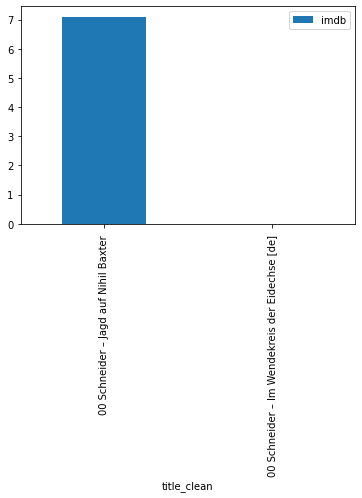

In [57]:
final_df.loc[df['series'] == series_names[0], ['imdb', 'title_clean']].set_index('title_clean').plot(kind='bar')

In [79]:
keep_series = pd.DataFrame(final_df.dropna(subset=['imdb']).groupby('series')['title'].count() == 1).reset_index()

In [91]:
keep_list = list(keep_series.loc[keep_series['title'] == False, 'series'])

In [93]:
output = final_df.loc[final_df['series'].isin(keep_list)]

In [105]:
json = output[['title_clean', 'series', 'date', 'imdb']].to_json(orient='records')

In [106]:
with open('movieData.json', 'w') as f:
    f.write(json)